# Cloud fraction/cover vs. cloud type as vertically stacked plots

We plot the cloud cover vs. cloud type.

## Load Standard and User Libraries

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import seaborn as sns
import pylab as pl

In [2]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3
import xarray as xr

In [3]:
import nawdex_analysis.analysis.ave_cre
import nawdex_analysis.io.collector

import nawdex_analysis.plot.stacked_analysis_plots
reload( nawdex_analysis.plot.stacked_analysis_plots)

from nawdex_analysis.plot.stacked_analysis_plots import vert_stacked_exp_plot, get_exp_kws, get_plotting_order

## Read Radiation Fluxes

This is a slight jump forward in time. Now, average radiation fluxes are available for different CT categories.

In [4]:
rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict' )
#rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'all' )
#rset = nawdex_analysis.io.collector.get_radflux4set( 2 )


In [5]:
rset

<xarray.Dataset>
Dimensions:        (ct: 11, idname: 16, time: 264)
Coordinates:
  * idname         (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct             (ct) |S18 'clear_ocean' 'very low' ... 'fractional'
  * time           (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
Data variables:
    afrac          (time, ct, idname) float64 22.11 21.22 23.02 ... 8.958 8.958
    swf_up_clear   (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net_clear  (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_down       (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf_clear      (time, ct, idname) float64 276.2 276.4 275.8 ... 272.9 270.9
    swf_up         (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net        (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf            (time, ct, idname) float64 274.5 274.3 274.1 ... 255.8 255.8
    expname        (time, idname) object 'nawdexnwp-1

## Adding fractional and vary low clouds

In [6]:
cset = rset.sel(ct = 'very low') + rset.sel(ct = 'fractional')
cset = cset.expand_dims('ct')
cset['ct'] = ['very low / fractional']

cset = xr.concat( [cset, rset], dim = 'ct' )

## Rename CT labels 

In [7]:
ctnames = cset.ct.data
ctnames[8] = 'semi. moderately thick'
ctnames[4] = 'mid-level'

In [8]:
cset.ct

<xarray.DataArray 'ct' (ct: 12)>
array(['very low / fractional', 'clear_ocean', 'very low', 'low', 'mid-level',
       'high opaque', 'very high opaque', 'semi. thin',
       'semi. moderately thick', 'semi. thick', 'semi. above', 'fractional'],
      dtype=object)
Coordinates:
  * ct       (ct) object 'very low / fractional' 'clear_ocean' ... 'fractional'

## Calculate Mean and STD

In [9]:
catlist = list( cset.ct.data )

remove_list = ['clear_ocean', 'semi. above', 'very low', 'fractional']

for rm_cat in remove_list:
    catlist.remove(rm_cat)


idlist = list( cset.idname.data )
idlist.remove( 'msevi-not_scaled' )

dset = cset.sel(ct = catlist, idname = idlist)
daily_mean = dset.groupby('time.day').mean('time')
# dvar = daily_mean.quantile([0.25, 0.5, 0.75], dim = 'day').diff('quantile')
dvar = daily_mean.std('day')
mvar = dset.mean('time')

/vols/fs1/store/senf/.conda/python27mod/lib/python2.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
dvar_q = ( daily_mean.quantile(0.84, 'day') - daily_mean.quantile(0.16, 'day')  ) /2.

In [11]:
mvar

<xarray.Dataset>
Dimensions:        (ct: 8, idname: 15)
Coordinates:
  * idname         (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct             (ct) object 'very low / fractional' 'low' ... 'semi. thick'
Data variables:
    afrac          (ct, idname) float64 30.11 30.67 28.36 ... 3.45 2.694 3.12
    swf_up_clear   (ct, idname) float64 77.78 77.9 77.93 ... 37.78 37.01 33.83
    swf_net_clear  (ct, idname) float64 -521.0 -523.6 -521.8 ... -224.1 -235.7
    swf_down       (ct, idname) float64 -598.8 -601.5 -599.7 ... -261.1 -269.7
    lwf_clear      (ct, idname) float64 545.5 546.7 545.3 ... 260.9 256.7 258.1
    swf_up         (ct, idname) float64 111.7 109.2 112.8 ... 99.21 101.3 107.2
    swf_net        (ct, idname) float64 -487.1 -492.3 -486.9 ... -159.8 -162.5
    lwf            (ct, idname) float64 532.7 533.8 532.3 ... 198.6 198.8 169.2

### Biases

In [12]:
daily_bias = daily_mean - daily_mean.sel(idname = 'msevi-scaled')


idlist = list( daily_bias.idname.data )
idlist.remove('msevi-scaled')

daily_bias = daily_bias.sel(idname = idlist)

mbias = daily_bias.mean('day')
dbias = daily_bias.std('day')

dbias_q = ( daily_bias.quantile(0.84, 'day') - daily_bias.quantile(0.16, 'day')  ) /2.

## Plotting

In [13]:
from nawdex_analysis.plot.legend import plegend, legend_renamer

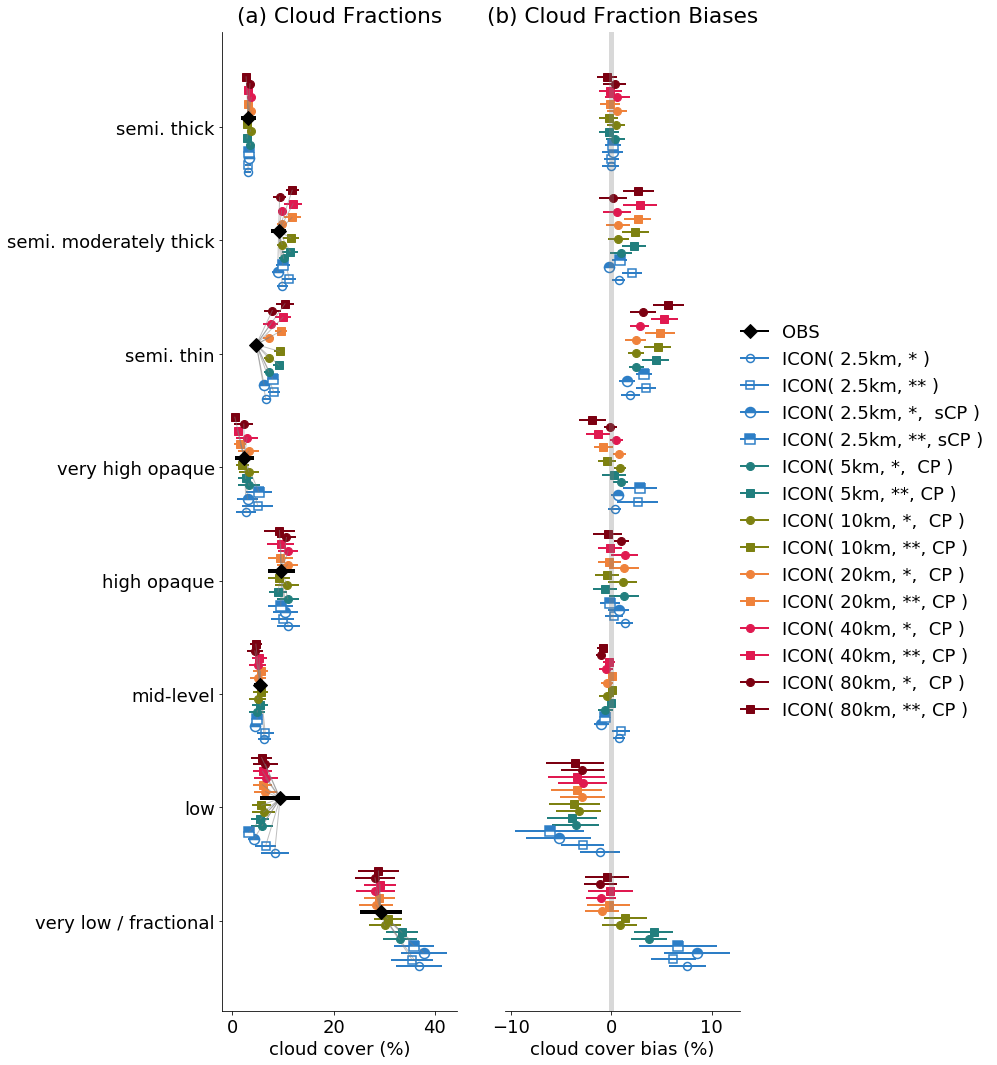

In [14]:
fig,ax  = pl.subplots( ncols = 2, figsize = (24, 18), )

pl.sca(ax[0])
vert_stacked_exp_plot( mvar, 'afrac' , var_err = dvar_q, doffset =0.06)

pl.xlabel( 'cloud cover (%)')
pl.title('(a) Cloud Fractions', pad = 10)
sns.despine(ax = ax[0])
plegend(bbox_to_anchor= (3.3, 0.5), fontsize = 'medium')

pl.sca(ax[1])
vert_stacked_exp_plot( mbias, 'afrac' , 
                       var_err = dbias_q, doffset = 0.06, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')

pl.xlabel( 'cloud cover bias (%)')
pl.title('(b) Cloud Fraction Biases', pad = 10)
pl.yticks([])
pl.axvline(0, color = 'gray', lw = 5, alpha = 0.3)

sns.despine(left = True, ax = ax[1])

pl.subplots_adjust( left = 0.3, right = 0.7 )


pl.subplots_adjust( left = 0.3, right = 0.6 )
pl.savefig( '../pics/cc-vs-ct.png', dpi = 300,)


# Appendix

## Why can be the error of the bias much larger the the actual-value error bar?

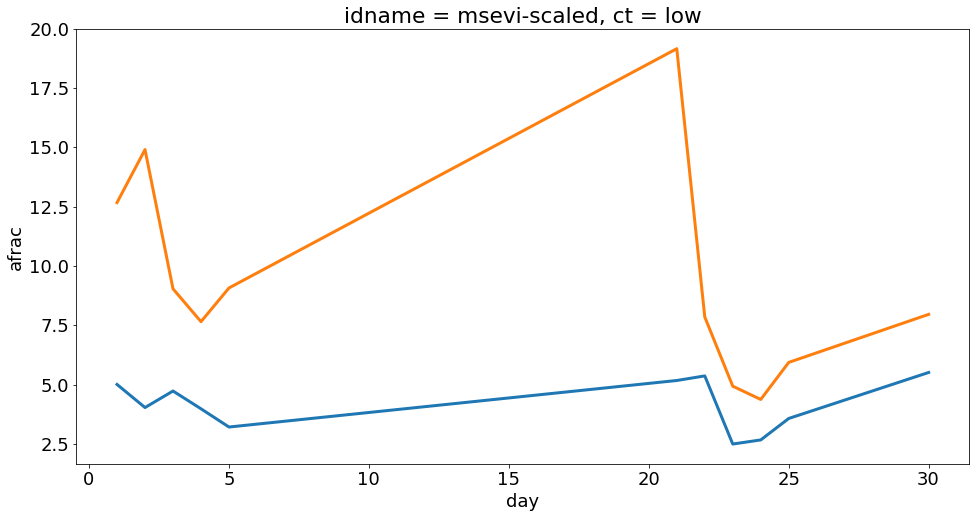

In [15]:
daily_mean.sel(ct = 'low', idname = '2km_oneMom_shConv')['afrac'].plot()
daily_mean.sel(ct = 'low', idname = 'msevi-scaled')['afrac'].plot()


In [16]:
daily_mean.sel(ct = 'low', idname = '2km_oneMom_shConv').std()

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    idname         |S17 '2km_oneMom_shConv'
    ct             |S3 'low'
Data variables:
    afrac          float64 1.028
    swf_up_clear   float64 0.9997
    swf_net_clear  float64 6.62
    swf_down       float64 7.218
    lwf_clear      float64 3.591
    swf_up         float64 7.687
    swf_net        float64 12.46
    lwf            float64 4.583

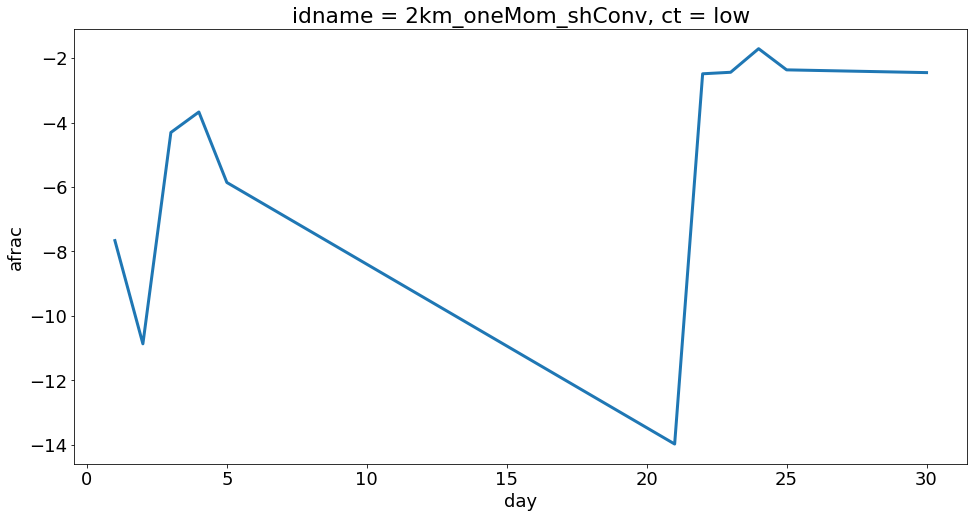

In [17]:
daily_bias.sel(ct = 'low', idname = '2km_oneMom_shConv')['afrac'].plot()

In [18]:
daily_bias.sel(ct = 'low', idname = '2km_oneMom_shConv').std()

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    idname         |S17 '2km_oneMom_shConv'
    ct             |S3 'low'
Data variables:
    afrac          float64 3.834
    swf_up_clear   float64 1.232
    swf_net_clear  float64 13.96
    swf_down       float64 14.89
    lwf_clear      float64 2.633
    swf_up         float64 9.121
    swf_net        float64 16.21
    lwf            float64 3.12

### Print CC values in table

In [19]:
cc_ave_obs = mvar['afrac'].sel( idname = 'msevi-scaled').to_pandas()
cc_ave_obs

ct
very low / fractional     29.264113
low                        9.409675
mid-level                  5.484949
high opaque                9.667847
very high opaque           2.353306
semi. thin                 4.700086
semi. moderately thick     9.118429
semi. thick                3.120169
dtype: float64

In [20]:
cc_ave_obs / cc_ave_obs.sum() * 100.

ct
very low / fractional     40.022817
low                       12.869063
mid-level                  7.501443
high opaque               13.222150
very high opaque           3.218479
semi. thin                 6.428032
semi. moderately thick    12.470743
semi. thick                4.267273
dtype: float64

## Plot CC biases

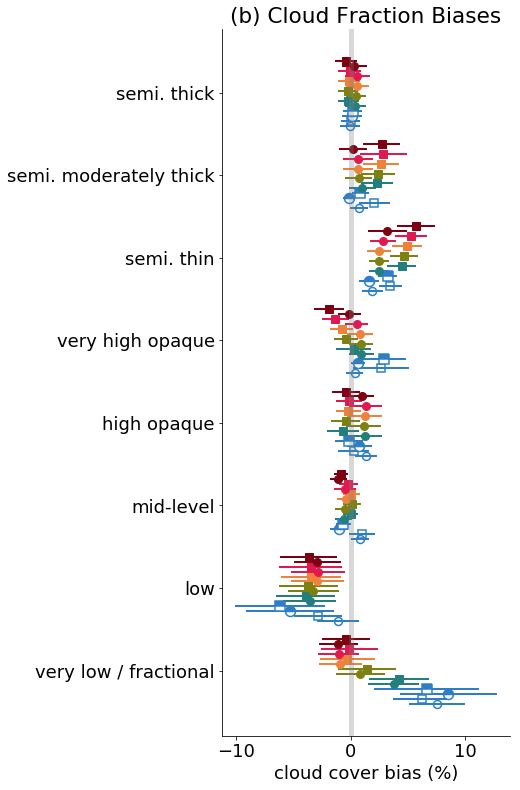

In [21]:
fig = pl.figure( figsize = (10, 13), )

vert_stacked_exp_plot( mbias, 'afrac' , 
                       var_err = dbias, doffset = 0.06, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')

pl.xlabel( 'cloud cover bias (%)')
pl.title('(b) Cloud Fraction Biases')
sns.despine()

pl.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
pl.subplots_adjust( left = 0.3, right = 0.7 )
pl.savefig( '../pics/ccbias-vs-ct.png', dpi = 300,)


## Bias Compensation

In [27]:
ctnames = ['low', 
           'mid-level', 
           'high opaque', #'very low / fractional',
           'very high opaque', 
           'semi. thin', 
           'semi. moderately thick', 
           'semi. thick'
          ]

mbias
bias_sum = mbias.sel(ct = ctnames).sum( 'ct' ).expand_dims( 'ct')
bias_sum['ct'] = ['all_but_very_low',]

bias2plot = xr.concat( [mbias.sel(ct = ['very low / fractional']), bias_sum], dim = 'ct')


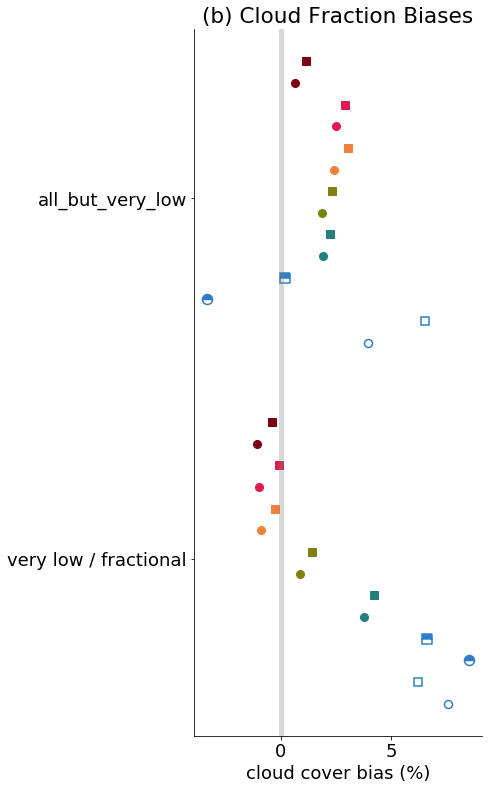

In [31]:
fig = pl.figure( figsize = (10, 13), )

vert_stacked_exp_plot( bias2plot, 'afrac' , 
                       var_err = None, doffset = 0.06, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')

pl.xlabel( 'cloud cover bias (%)')
pl.title('(b) Cloud Fraction Biases')
sns.despine()

pl.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
pl.subplots_adjust( left = 0.3, right = 0.7 )